## Load Data

In [1]:
import os
import glob
import pandas as pd
from tqdm.auto import tqdm
import time
import numpy as np
import numpy.ma as ma

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


Using TensorFlow backend.


In [2]:


sensor_list = ['act', 'acw', 'dc', 'pm']
# Test out the read in helper function
def get_subject_action(sensor, full_path):
    index = full_path.find(sensor)
    index += len(sensor)
    subject = int(full_path[index+1:index+3])
    action = int(full_path[index+4:index+6])
    if action == 4:
        if full_path.find(f"{sensor}_1") > 0:
            action = '4-1'
        else:
            action = '4-2'
        
    return (subject, str(action))

for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                #print(full_path, get_subject_action(sensor, full_path))
                
test_str = '.\\data\\act\\01\\01_act_1.csv'
get_subject_action('act', test_str)

On act
On acw
On dc
On pm


(1, '1')

In [325]:
%%time
total_data = {
    'act': None,
    'acw': None,
    'dc': None,
    'pm': None,
}


headers = {
    'act': ['times', 'X', 'Y', 'Z'],
    'acw': ['times', 'X', 'Y', 'Z'],
    'dc': ['times'],
    'pm': ['times']
}
for i in range(1,513):
    headers['pm'].append(f"sensor_{i}")
for i in range(1,193):
    headers['dc'].append(f"sensor_{i}")

actions = ['1', '2', '3', '4-1', '4-2', '5', '6', '7']

sensor_list = ['act', 'acw', 'dc', 'pm']
#sensor_list = ['acw']

# there are 956 files in our dataset
i = 0

pbar = tqdm(desc="load data", total=956)
for sensor in sensor_list:
    for sensor_dir in glob.iglob('.\\data\\' + sensor ):
        #print(f"On {sensor}")
        for subject_id, subject_dir in enumerate(glob.iglob(f"{sensor_dir}\\*")):
            for action_id, file in enumerate(os.listdir(subject_dir)):
                full_path = f"{subject_dir}\\{file}"
                df_tmp = pd.read_csv(full_path, names=headers[sensor])
                i+=1
                pbar.update(1)
                subject, action = get_subject_action(sensor, full_path)
                # add one to make it match the given format
                df_tmp['subject'] = subject
                df_tmp['action'] = action
                if total_data[sensor] is None:
                    total_data[sensor] = df_tmp
                else:
                    total_data[sensor] = pd.concat([total_data[sensor], df_tmp])

load data:   0%|          | 0/956 [00:00<?, ?it/s]

Wall time: 1min 49s


In [326]:
total_data['dc'].head()

,times,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_185,sensor_186,sensor_187,sensor_188,sensor_189,sensor_190,sensor_191,sensor_192,subject,action
0,2018-11-08 11:34:51.538000,0.4583,0.9214,0.9221,0.9167,0.9136,0.9136,0.9106,0.9075,0.9052,...,0.9429,0.6804,0.936,0.936,0.9360,0.9329,0.926,0.9279,1,1
1,2018-11-08 11:34:51.632000,0.4583,0.9214,0.9214,0.9167,0.9144,0.9136,0.9106,0.9075,0.9060,...,0.9429,0.9150,0.936,0.936,0.9360,0.9352,0.926,0.9279,1,1
2,2018-11-08 11:34:51.804000,0.4583,0.9214,0.9214,0.9167,0.9136,0.9121,0.9121,0.9075,0.9060,...,0.9429,0.9165,0.936,0.936,0.9360,0.9329,0.926,0.9260,1,1
3,2018-11-08 11:34:51.977000,0.4591,0.9214,0.9206,0.9167,0.9136,0.9128,0.9106,0.9075,0.9060,...,0.9429,0.9150,0.936,0.936,0.9345,0.9329,0.926,0.9260,1,1
4,2018-11-08 11:34:52.133000,0.4591,0.9214,0.9198,0.9167,0.9144,0.9136,0.9106,0.9075,0.9060,...,0.9429,0.6804,0.936,0.936,0.9360,0.9329,0.926,0.9260,1,1


In [327]:
total_data['act'].head()

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,-0.546875,-0.828125,-0.109375,1,1
1,2018-11-08 11:34:51.484000,-0.531250,-0.828125,-0.109375,1,1
2,2018-11-08 11:34:51.494000,-0.531250,-0.828125,-0.109375,1,1
3,2018-11-08 11:34:51.504000,-0.531250,-0.843750,-0.109375,1,1
4,2018-11-08 11:34:51.513000,-0.515625,-0.843750,-0.109375,1,1


In [328]:
total_data['acw'].head()
df_grouped = total_data['acw'].groupby(["subject","action"]).count()
type(df_grouped)
print('mean', df_grouped["times"].mean())
print('median', df_grouped["times"].median())
print('max', df_grouped["times"].max())
print('min', df_grouped["times"].min())
print('count', df_grouped["times"].count())

mean 5496.6317991631795
median 6042.0
max 11320
min 1628
count 239


In [329]:
total_data['pm'].head()

,times,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_505,sensor_506,sensor_507,sensor_508,sensor_509,sensor_510,sensor_511,sensor_512,subject,action
0,2018-11-08 11:34:51.468000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,68.0,77.0,55.0,193.0,387.0,331.0,125.0,6.0,1,1
1,2018-11-08 11:34:51.535000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,58.0,78.0,53.0,192.0,388.0,330.0,123.0,6.0,1,1
2,2018-11-08 11:34:51.602000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,78.0,53.0,195.0,390.0,330.0,119.0,7.0,1,1
3,2018-11-08 11:34:51.669000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,66.0,79.0,55.0,196.0,391.0,324.0,106.0,5.0,1,1
4,2018-11-08 11:34:51.737000,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,...,64.0,79.0,55.0,194.0,391.0,321.0,114.0,6.0,1,1


In [330]:
for key in total_data.keys():
    if total_data[key] is not None:
        print(key)
        print(total_data[key]['action'].unique())
        print(total_data[key]['subject'].unique())
        for header in headers[key]:
            if(total_data[key][header].isnull().values.any()):
                print(f"{header} has Null data")
        print(total_data[key].info())
        print('-------------------------------------------------------------------------')

act
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1400856 entries, 0 to 6418
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   times    1400856 non-null  object 
 1   X        1400856 non-null  float64
 2   Y        1400856 non-null  float64
 3   Z        1400856 non-null  float64
 4   subject  1400856 non-null  int64  
 5   action   1400856 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 74.8+ MB
None
-------------------------------------------------------------------------
acw
['1' '2' '3' '4-1' '4-2' '5' '6' '7']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313695 entries, 0 to 6013
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  -----

### Play around with the data

In [349]:
df_pm = total_data['pm']
sensors = [f"sensor_{i}" for i in range(1, 513)]
df_pm[(df_pm.subject == 1) & (df_pm.action == '1')][sensors]

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_503,sensor_504,sensor_505,sensor_506,sensor_507,sensor_508,sensor_509,sensor_510,sensor_511,sensor_512
0,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,88.0,94.0,68.0,77.0,55.0,193.0,387.0,331.0,125.0,6.0
1,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,104.0,93.0,58.0,78.0,53.0,192.0,388.0,330.0,123.0,6.0
2,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,106.0,93.0,64.0,78.0,53.0,195.0,390.0,330.0,119.0,7.0
3,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,108.0,94.0,66.0,79.0,55.0,196.0,391.0,324.0,106.0,5.0
4,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,125.0,94.0,64.0,79.0,55.0,194.0,391.0,321.0,114.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,50.0,72.0,112.0,64.0,64.0,43.0,30.0,17.0,3.0,0.0
963,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,48.0,71.0,107.0,65.0,60.0,41.0,31.0,16.0,0.0,0.0
964,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,50.0,73.0,105.0,70.0,64.0,47.0,32.0,15.0,2.0,0.0
965,20.0,3.0,2.0,0.0,0.0,0.0,72.0,1493.0,1949.0,0.0,...,53.0,73.0,104.0,67.0,62.0,47.0,34.0,14.0,0.0,0.0


In [ ]:
%%time
# lets reshape it to have 5 samples per line.
subject = 1
action = '1'
df_depth_camera = total_data['dc'][(total_data['dc']['subject'] == subject) & (total_data['pm']['action'] == action )]

In [355]:
%%time
df_dc = total_data['dc']
df_dc[(df_dc.subject == subject) & (df_dc.action == '1')]

Wall time: 8.98 ms


,times,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_185,sensor_186,sensor_187,sensor_188,sensor_189,sensor_190,sensor_191,sensor_192,subject,action
0,2018-11-08 11:34:51.538000,0.4583,0.9214,0.9221,0.9167,0.9136,0.9136,0.9106,0.9075,0.9052,...,0.9429,0.6804,0.936,0.936,0.9360,0.9329,0.9260,0.9279,1,1
1,2018-11-08 11:34:51.632000,0.4583,0.9214,0.9214,0.9167,0.9144,0.9136,0.9106,0.9075,0.9060,...,0.9429,0.9150,0.936,0.936,0.9360,0.9352,0.9260,0.9279,1,1
2,2018-11-08 11:34:51.804000,0.4583,0.9214,0.9214,0.9167,0.9136,0.9121,0.9121,0.9075,0.9060,...,0.9429,0.9165,0.936,0.936,0.9360,0.9329,0.9260,0.9260,1,1
3,2018-11-08 11:34:51.977000,0.4591,0.9214,0.9206,0.9167,0.9136,0.9128,0.9106,0.9075,0.9060,...,0.9429,0.9150,0.936,0.936,0.9345,0.9329,0.9260,0.9260,1,1
4,2018-11-08 11:34:52.133000,0.4591,0.9214,0.9198,0.9167,0.9144,0.9136,0.9106,0.9075,0.9060,...,0.9429,0.6804,0.936,0.936,0.9360,0.9329,0.9260,0.9260,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2018-11-08 11:35:56.050000,0.4583,0.9214,0.9206,0.9167,0.9136,0.9136,0.9121,0.9075,0.9060,...,0.9429,0.9167,0.936,0.936,0.6345,0.6160,0.9260,0.9279,1,1
626,2018-11-08 11:35:56.109000,0.4599,0.9221,0.9229,0.9167,0.9151,0.9128,0.9121,0.9075,0.9060,...,0.9429,0.9152,0.936,0.936,0.8618,0.5418,0.9260,0.9288,1,1
627,2018-11-08 11:35:56.187000,0.4583,0.9206,0.9198,0.9167,0.9144,0.9136,0.9121,0.9075,0.9060,...,0.9429,0.9150,0.936,0.936,0.9360,0.9337,0.9298,0.9279,1,1
628,2018-11-08 11:35:56.249000,0.4583,0.9214,0.9221,0.9167,0.9151,0.9128,0.9113,0.9075,0.9060,...,0.9429,0.6810,0.936,0.936,0.9360,0.9329,0.9288,0.9288,1,1


# New attpempt.
Sample each observartion into equal chunks to

## Get the y data

In [13]:
df_wrist = total_data['acw']
df_wrist.head()

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1


In [14]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df_wrist['action'].values)
df_wrist['action_encoded'] = y

y_ohe = keras.utils.to_categorical(df_wrist['action_encoded'])

df_wrist.head()

,times,X,Y,Z,subject,action,action_encoded
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1,0
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1,0
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1,0
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1,0
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1,0


In [15]:
df_y = pd.get_dummies(df_wrist.action, prefix='action_ohe')

y_ohe_columns = df_y.columns

df_wrist = pd.concat([df_wrist, df_y], axis=1)

In [16]:
df_y.columns

Index(['action_ohe_1', 'action_ohe_2', 'action_ohe_3', 'action_ohe_4-1',
       'action_ohe_4-2', 'action_ohe_5', 'action_ohe_6', 'action_ohe_7'],
      dtype='object')

In [17]:
df_wrist.head()

,times,X,Y,Z,subject,action,action_encoded,action_ohe_1,action_ohe_2,action_ohe_3,action_ohe_4-1,action_ohe_4-2,action_ohe_5,action_ohe_6,action_ohe_7
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1,0,1,0,0,0,0,0,0,0
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1,0,1,0,0,0,0,0,0,0
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1,0,1,0,0,0,0,0,0,0
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1,0,1,0,0,0,0,0,0,0
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1,0,1,0,0,0,0,0,0,0


### Testing out a SIMPLE RNN on just the wrist data

In [134]:
np.arange(2,10)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [160]:
# Generator from page 211 from text book (first edition)
def generator(data, target, lookback, min_index,
              max_index, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - 1
    i = min_index + lookback
    cnt = 0
    while 1:
        
        if i + batch_size >= max_index:
            yield None, None
        rows = np.arange(i, min(i + batch_size, max_index))
        
        

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows), len(y_ohe_columns)))
        for j, row in enumerate(rows):
            indicies = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indicies]
            targets[j] = target
        cnt += 1
        i += samples.shape[1]
        yield samples, targets

## This is used to count how many more next()'s we have to call

In [236]:
def count_total_steps(data, target, lookback, min_index,
                      max_index, batch_size=128, step=1):
    
    cnt = 0
    gen = generator(data, target, lookback, min_index, max_index, batch_size=128, step=1)
    samples, target = next(gen)
    while samples is not None:
        cnt += 1
        samples, target = next(gen)
        
    return cnt

def count_total_steps_set(df, subjects, lookback, min_index,
                          max_index, batch_size=128, step=1):
    
    cnt = 0
    for subject in subjects:
        actions = df[df['subject'] == subject]['action'].unique()
        for action in actions:
            df_subset = df[(df['action'] == action) & (df['subject'] == subject)]
            x_data = df_subset[["X", "Y", "Z"]].to_numpy()
            target = df_subset[y_ohe_columns].to_numpy()[0]
            cnt += count_total_steps(x_data, target, lookback, min_index,
                          max_index, batch_size, step)
    return cnt

subjects = [1,1]
count_total_steps_set(df_wrist, subjects, lookback=500, min_index=0,
                      max_index=None, batch_size=1, step=1)

176

In [237]:
def parent_generator(df, lookback, min_index,
                     max_index, batch_size=128, step=1):
    
    subjects = df['subject'].unique()
    idx_subjects = 0
    actions = df[df['subject'] == subjects[idx_subjects]]['action_encoded'].unique()
    idx_actions = 0
    data = df[(df['subject'] == subjects[idx_subjects]) 
              & (df['action_encoded'] == actions[idx_actions])]
    
    data = data[["X", "Y", "Z"]]
    target = df[y_ohe_columns].to_numpy()[0]
    gen = generator(data.to_numpy(), target, lookback, min_index=0,
                    max_index=None, batch_size=batch_size, step=step)
    
    samples, targets = next(gen)
    while 1:
        while samples is not None:
            yield samples, targets
            samples, targets = next(gen)
        idx_actions += 1
        if idx_actions >= len(actions):
            actions = df[df['subject'] == subjects[idx_subjects]]['action_encoded'].unique()
            idx_actions = 0
            idx_subjects = (idx_subjects + 1) % len(subjects)
        
        data = df[(df['subject'] == subjects[idx_subjects]) 
                  & (df['action_encoded'] == actions[idx_actions])]
        data = data[["X", "Y", "Z"]]
        target = df[y_ohe_columns].to_numpy()[0]
        gen = generator(data.to_numpy(), target, lookback, min_index=0,
                        max_index=None, batch_size=batch_size, step=step)
        samples, targets = next(gen)
    
        
                
        

In [238]:
df_wrist[df_wrist['subject'] == 22]['action_encoded'].unique()

array([0, 1, 2, 3, 5, 6, 7])

## Temprarily split into train and test

In [239]:
tmp = df_wrist[df_wrist['subject'] == 22]['action'].unique()
tmp

array(['1', '2', '3', '4-1', '5', '6', '7'], dtype=object)

In [240]:
test_steps = count_total_steps_set(df_wrist, range(21,31), lookback=500, min_index=0,
                                   max_index=None, batch_size=1, step=1)
train_steps = count_total_steps_set(df_wrist, range(1,21), lookback=500, min_index=0,
                                    max_index=None, batch_size=1, step=1)
print(test_steps, train_steps)

813 1624


In [287]:
# Use subject 1-20 as train and 21-30 as test.
df_train = df_wrist[(df_wrist['subject'] >= 1) & df_wrist['subject'] <= 20]
df_test = df_wrist[(df_wrist['subject'] >= 21) & df_wrist['subject'] <= 30]
gen_train = parent_generator(df_train, lookback=500, min_index=0,
                             max_index=None, batch_size=1, step=1)

gen_test = parent_generator(df_test, lookback=500, min_index=0,
                            max_index=None, batch_size=1, step=1)

In [288]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(500,3), return_sequences=True))
model.add(layers.SimpleRNN(128))
model.add(layers.Dense(64))
model.add(layers.Dense(8, activation='softmax'))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, 500, 32)           3456      
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 128)               20608     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 8)                 520       
Total params: 32,840
Trainable params: 32,840
Non-trainable params: 0
_________________________________________________________________


In [323]:
from tensorflow.keras.layers import Dense, Activation, Input, GRU, SimpleRNN
from tensorflow.keras.models import Model
input_wrist = Input(shape=(500,3))
x = GRU(units=32, return_sequences=True)(input_wrist)
x = SimpleRNN(units=16)(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
predictions = Dense(units=8, activation='softmax')(x)

model = Model(inputs=input_wrist, outputs=predictions)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 500, 3)]          0         
_________________________________________________________________
gru_21 (GRU)                 (None, 500, 32)           3552      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_21 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 1032      
Total params: 42,616
Trainable params: 42,616
Non-trainable params: 0
_______________________________________________________

In [324]:
%%time
history = model.fit_generator(gen_train,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=gen_test,
                              validation_steps=813)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 813 steps
Epoch 1/50
100/100 [==============================] - 44s 440ms/step - loss: 0.0164 - val_loss: 1.0600e-04
Epoch 2/50
100/100 [==============================] - 42s 423ms/step - loss: 4.2886e-06 - val_loss: 2.6887e-05
Epoch 3/50
100/100 [==============================] - 42s 425ms/step - loss: 8.5420e-08 - val_loss: 4.1171e-05
Epoch 4/50
100/100 [==============================] - 43s 427ms/step - loss: 4.9714e-09 - val_loss: 4.4062e-05
Epoch 5/50
100/100 [==============================] - 42s 423ms/step - loss: 2.2323e-06 - val_loss: 1.2682e-05
Epoch 6/50
100/100 [==============================] - 43s 428ms/step - loss: 5.3901e-09 - val_loss: 1.1142e-05
Epoch 7/50
100/100 [==============================] - 42s 423ms/step - loss: 2.0834e-09 - val_loss: 3.3603e-07
Epoch 8/50
100/100 [==============================] - 42s 421ms/step - loss: 9.8240e-09 - val_loss: 1.2422e-05
Epoch 9/50
100/100 [==

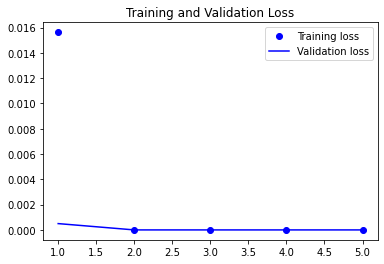

In [319]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [271]:
score = model.evaluate_generator(generator=gen_test,
                                 steps=813)
score

1.1123903187471029e-10

In [282]:
pred = model.predict_generator(generator=gen_test,
                                steps=12)
predicted_class_indices = np.argmax(pred,axis=1)
predicted_class_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

__________________

In [94]:
df_wrist_sample_1 = df_wrist[(df_wrist['subject'] == 1) & (df_wrist['action'] == '1')]
df_wrist_sample_1.head()

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1


In [95]:
data_X = df_wrist_sample_1[['X', 'Y', 'Z']].to_numpy()
data_X

array([[ 0.125   , -0.046875,  0.90625 ],
       [ 0.109375, -0.0625  ,  0.90625 ],
       [ 0.109375, -0.0625  ,  0.90625 ],
       ...,
       [ 0.09375 , -0.265625,  0.875   ],
       [ 0.09375 , -0.265625,  0.875   ],
       [ 0.09375 , -0.265625,  0.875   ]])

In [86]:
data_Y = df_wrist_sample_1['action'].to_numpy()
data_Y

array(['1', '1', '1', ..., '1', '1', '1'], dtype=object)

In [87]:
###### print(data_X.shape)
ret = generator(data_X, '1', lookback=1000, min_index=0,
                max_index=None, step=5, batch_size=1)
train, test = next(ret)
ct = 0
samps = []
while train is not None:
    ct += 1
    train, test = next(ret)
    if train is not None:
        samps.append(train)
        
print(ct)

5222


--------

In [55]:

x = []
y = []

for subject in df_wrist['subject'].unique():
    for action in df_wrist['action'].unique():
        subset = df_wrist[(df_wrist['subject'] == subject) & (df_wrist['action'] == action)]
        a = subset[["X", "Y", "Z"]].to_numpy()
        x.append(a)
        y.append(action)

In [60]:
x = np.array(x, dtype=object)
y = np.array(y)

In [61]:
x.shape

(240,)

In [62]:
y.shape

(240,)

In [63]:
tf.random.set_seed(1)

In [64]:
## build the model
lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(3,1), name='input-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, name='lstm-layer'),
        name='bidir-lstm'), 

    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidir-lstm (Bidirectional)   (None, 128)               33792     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 42,113
Trainable params: 42,113
Non-trainable params: 0
_________________________________________________________________


In [65]:

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [66]:


history = lstm_model.fit(
    x=x,
    y=y,
    epochs=10)

ValueError: Error when checking input: expected input-layer to have 3 dimensions, but got array with shape (240, 1)

In [85]:
x[1].shape

(5958, 3)

In [87]:
model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=(20 //3, x.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(8))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                46112     
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 264       
Total params: 46,376
Trainable params: 46,376
Non-trainable params: 0
_________________________________________________________________


In [93]:
x[1]

array([[-0.484375, -0.53125 , -0.75    ],
       [-0.484375, -0.546875, -0.734375],
       [-0.46875 , -0.546875, -0.734375],
       ...,
       [ 0.234375, -0.578125, -0.796875],
       [ 0.25    , -0.578125, -0.78125 ],
       [ 0.234375, -0.578125, -0.78125 ]])

In [125]:
model_test = tf.keras.Sequential()
model_test.add(layers.LSTM(50, input_shape=(240, 3)))
model_test.add(layers.Dense(1))
model_test.compile(loss='mae', optimizer='adam')
model_test.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [126]:
hist = model_test.fit(x, y, epochs=10)

ValueError: Error when checking input: expected lstm_9_input to have 3 dimensions, but got array with shape (240, 1)

In [77]:
from keras.optimizers import RMSprop

In [81]:

model.compile(optimizer='adam', loss='mse')

In [82]:
model.fit(x=x, y=y, epochs=10)

ValueError: Error when checking input: expected flatten_1_input to have 3 dimensions, but got array with shape (240, 1)

------

In [8]:
df_wrist = total_data['acw']

In [9]:
df_wrist.head()

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1


In [55]:
df_wrist['subject'].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

In [68]:
df_wrist[(df_wrist['subject'] == 1) & (df_wrist['action'] == '1')]

,times,X,Y,Z,subject,action
0,2018-11-08 11:34:51.474000,0.125000,-0.046875,0.90625,1,1
1,2018-11-08 11:34:51.485000,0.109375,-0.062500,0.90625,1,1
2,2018-11-08 11:34:51.495000,0.109375,-0.062500,0.90625,1,1
3,2018-11-08 11:34:51.505000,0.125000,-0.062500,0.90625,1,1
4,2018-11-08 11:34:51.516000,0.125000,-0.062500,0.90625,1,1
...,...,...,...,...,...,...
6269,2018-11-08 11:35:56.373000,0.093750,-0.265625,0.87500,1,1
6270,2018-11-08 11:35:56.383000,0.093750,-0.281250,0.87500,1,1
6271,2018-11-08 11:35:56.394000,0.093750,-0.265625,0.87500,1,1
6272,2018-11-08 11:35:56.404000,0.093750,-0.265625,0.87500,1,1


In [77]:
A = np.array([[1, 2, 3], [4, 5, 6]])
A

array([[1, 2, 3],
       [4, 5, 6]])

In [78]:
B = np.array([0, 1, 0, 1, 0, 1])

array([0, 1])

In [ ]:
# Reformate the data to be each sample X, Y, Z, X, Y, Z, ....
X = ma.empty

for subject in df_wrist['subject'].unique():
    for action in df_wrist['action'].unique():
        subset = df_wrist[(df_wrist['subject'] == subject) & (df_wrist['action'] == action)]
        tmp_np = subset.to_numpy()
        tmp_shape = tmp_np.shape
        tmp_np = tmp_np.reshape(1, tmp_shape[0] * tmp_shape[1])
        print(tmp_np.shape)
        X = np.vstack([X, tmp_np])
        break
    break

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



(1, 37644)
Traceback (most recent call last):
  File "C:\Users\Nick\anaconda3\envs\mlenv2022\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Nick\AppData\Local\Temp/ipykernel_11344/4143097367.py", line 11, in <module>
    X = np.vstack([X, tmp_np])
  File "<__array_function__ internals>", line 6, in vstack
  File "C:\Users\Nick\anaconda3\envs\mlenv2022\lib\site-packages\numpy\core\shape_base.py", line 282, in vstack
    return _nx.concatenate(arrs, 0)
  File "<__array_function__ internals>", line 6, in concatenate
ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 37644

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Nick\anaconda3\envs\mlenv2022\lib\site-packages\IPython\core\interactivesh